In [1]:
import numpy as np 
import matplotlib.pylab as plt 
from scipy.integrate import dblquad
import torch 
import warnings
warnings.filterwarnings('ignore')

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 20

In [2]:
def sinusoidal(xvalues: torch.tensor, parameters: torch.tensor) -> torch.tensor:
      
    return parameters[0] * torch.sin(parameters[1] * xvalues)

def quadratic(xvalues: torch.tensor, parameters: torch.tensor) -> torch.tensor:
        
    return parameters[0]*xvalues**2 + parameters[1]*xvalues

### Plot the Functions

In [3]:
xmin = 0.0
xmax = torch.pi
npoint = 1000
xvals = torch.linspace(xmin, xmax, npoint)

amplitude = 4.0
angFreq = 0.75
sin_parameters = torch.tensor([amplitude, angFreq])
sinFunction = sinusoidal(xvals, sin_parameters)

a_param = -1.0
b_param = 4.0
quad_parameters = torch.tensor([a_param, b_param])
quadFunction = quadratic(xvals, quad_parameters)

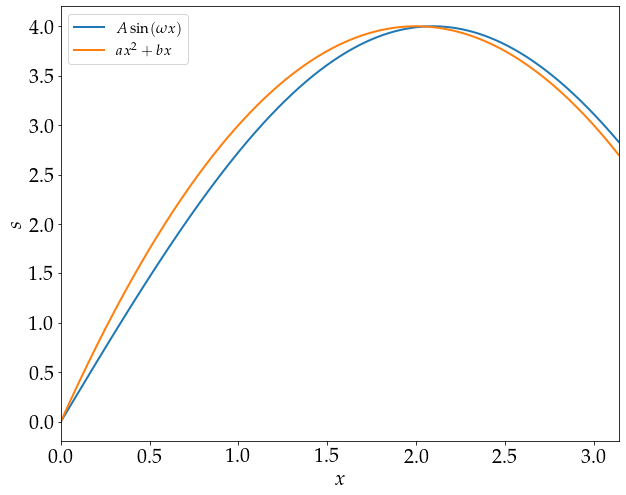

In [4]:
plt.figure(figsize = (10, 8))
plt.plot(xvals, sinFunction, lw = 2, label = r'$A\,\textrm{sin}(\omega x)$')
plt.plot(xvals, quadFunction, lw = 2, label = r'$ax^{2}+bx$')
plt.xlim(xmin, xmax)
plt.ylabel(r'$s$', fontsize = fontSize)
plt.xlabel(r'$x$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
plt.show()

### Generate the Data

We will be using the sinusoidal signal to generate the data. 

**Assumptions**
- Uncorrelated noise (diagonal covariance matrix)
- Number of data points, $N_{\textrm{data}}=50$
- $A=4.0$
- $\omega=0.75$
- $\sigma = 0.1$

In [5]:
ndata = 50
sigma = 0.1
xinputs = torch.linspace(xmin, xmax, ndata)
data = sinusoidal(xinputs, sin_parameters) + torch.empty(ndata).normal_(mean=0.0,std=sigma)

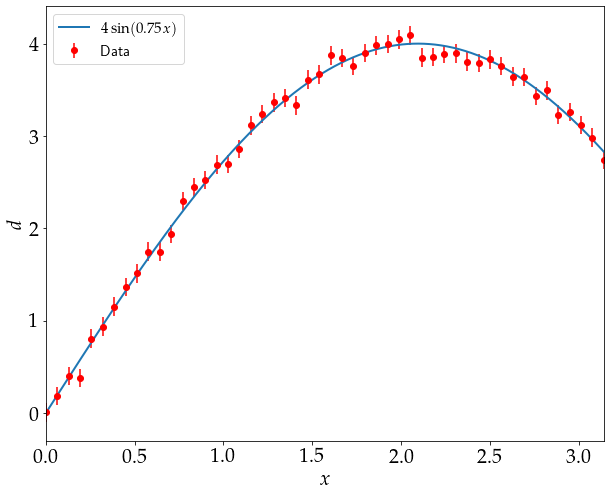

In [6]:
plt.figure(figsize = (10, 8))
plt.plot(xvals, sinFunction, lw = 2, label = r'$4\,\textrm{sin}(0.75 x)$')
plt.errorbar(xinputs, data, yerr = 0.1, fmt = 'ro', label = 'Data')
plt.xlim(xmin, xmax)
plt.ylabel(r'$d$', fontsize = fontSize)
plt.xlabel(r'$x$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
plt.show()

### Likelihood

We will work with two models. 

- $s_{1} = A\,\textrm{sin}(\omega x)$
- $s_{2} = ax^{2} + bx$

$$\textrm{log }p(d|\boldsymbol{\theta})=-\dfrac{1}{2}\sum_{i=1}^{N}\left(\dfrac{d_{i}-s_{i}}{\sigma_{i}}\right)^{2}-\dfrac{N}{2}\textrm{log}(2\pi\sigma^{2})$$

In [7]:
def loglike(data: torch.tensor, xvalues: torch.tensor, parameters: torch.tensor, sigma: float = 0.1, sin: bool = True) -> float:
    
    # the function/model/signal
    if sin:
        signal = sinusoidal(xvalues, parameters)
        
    else:
        signal = quadratic(xvalues, parameters)
    
    # number of data points
    ndata = data.shape[0]
    
    # difference between the data and the signal
    epsilon = data - signal
    
    # the chi2 term
    chi2 = torch.sum((epsilon/sigma)**2)
    
    # the constant term
    constant = torch.tensor([2.0 * torch.pi * sigma**2])
    constant = ndata * torch.log(constant)
    
    return -0.5 * (chi2.item() + constant.item())

### Calculate the likelihood values

For the sinusoidal function.

In [8]:
amp_min = 3.9
amp_max = 4.1
ang_min = 0.73
ang_max = 0.78
npoints = 200

amp = torch.linspace(amp_min, amp_max, npoints)
ang = torch.linspace(ang_min, ang_max, npoints)
amp_grid, ang_grid = torch.meshgrid(amp, ang, indexing='ij')

In [9]:
logL_sin = list()
for a in amp:
    for g in ang:
        param = torch.tensor([a, g])
        logL_sin.append(loglike(data, xinputs, param, sigma, True))

In [10]:
logL_sin = torch.FloatTensor(logL_sin).view(npoints, npoints)

Find the maximum likelihood estimator when using the sinusoidal model. Will be useful for calculating the compression vectors, for example, $\boldsymbol{b}$ (in MOPED notations). 

In [11]:
id_max_sin = np.unravel_index(torch.argmax(logL_sin), logL_sin.shape)
sin_mle = [amp[id_max_sin[0]].item(), ang[id_max_sin[1]]]

In [12]:
print(f'The MLE using the sinusoidal model is {sin_mle[0]:.3f} and {sin_mle[1]:.3f}.')

The MLE using the sinusoidal model is 3.993 and 0.753.


For the quadratic model.

In [13]:
a_min = -1.0
a_max = -0.8
b_min = 3.5
b_max = 3.8


a_quad = torch.linspace(a_min, a_max, npoints)
b_quad = torch.linspace(b_min, b_max, npoints)
a_grid, b_grid = torch.meshgrid(a_quad, b_quad, indexing='ij')

In [14]:
logL_quad = list()
for a in a_quad:
    for b in b_quad:
        param = torch.tensor([a, b])
        logL_quad.append(loglike(data, xinputs, param, sigma, False))

In [15]:
logL_quad = torch.FloatTensor(logL_quad).view(npoints, npoints)

Find the maximum likelihood estimator when using the quadratic model. Will be useful for calculating the compression vectors, for example, $\boldsymbol{b}$ (in MOPED notations). 

In [16]:
id_max_quad = np.unravel_index(torch.argmax(logL_quad), logL_quad.shape)
quad_mle = [a_quad[id_max_quad[0]].item(), b_quad[id_max_quad[1]]]

In [17]:
print(f'The MLE using the quadratic model is {quad_mle[0]:.3f} and {quad_mle[1]:.3f}.')

The MLE using the quadratic model is -0.878 and 3.696.


### Visualise the contours

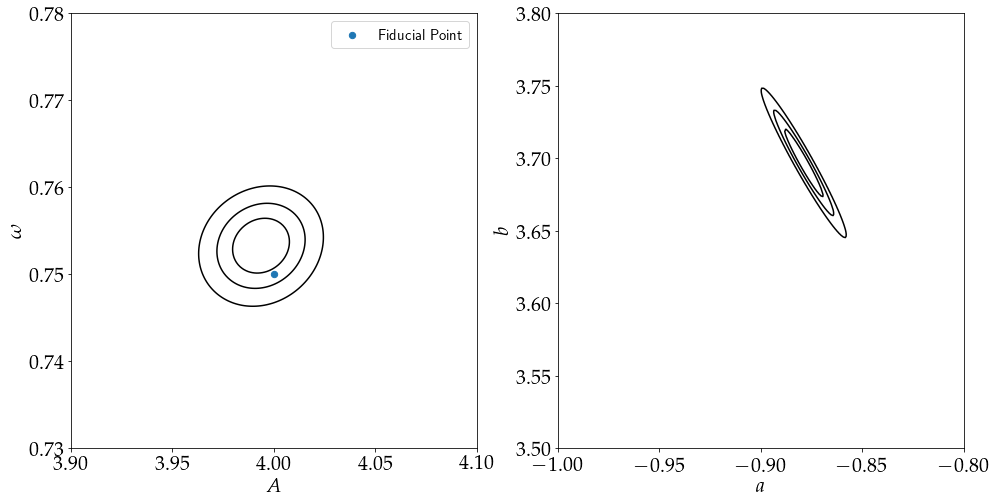

In [18]:
plt.figure(figsize = (16,8))
plt.subplot(121)
contours = plt.contour(amp_grid, ang_grid, torch.exp(logL_sin - torch.amax(logL_sin)), 3, colors='black')
contours.collections[0].remove()
plt.scatter([amplitude], [angFreq], s = 40, label = 'Fiducial Point')
plt.xlim(amp_min, amp_max)
plt.ylim(ang_min, ang_max)
plt.ylabel(r'$\omega$', fontsize = fontSize)
plt.xlabel(r'$A$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})

plt.subplot(122)
contours = plt.contour(a_grid, b_grid, torch.exp(logL_quad - torch.amax(logL_quad)), 3, colors='black')
contours.collections[0].remove()
plt.ylim(b_min, b_max)
plt.xlim(a_min, a_max)
plt.ylabel(r'$b$', fontsize = fontSize)
plt.xlabel(r'$a$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.show()

### Priors

*Priors for the parameters in the first model*

- $p(A) = \mathcal{N}(4.0, 1.0)$
- $p(\omega) = \mathcal{N}(0.75, 1.0)$

*Priors for the parameters in the second model*

- $p(a) = \mathcal{N}(-1.0, 1.0)$
- $p(b) = \mathcal{N}(4.0, 1.0)$


In [19]:
prior_amp = torch.distributions.normal.Normal(torch.tensor([4.0]), torch.tensor([1.0]))
prior_ang = torch.distributions.normal.Normal(torch.tensor([0.75]), torch.tensor([1.0]))
prior_a = torch.distributions.normal.Normal(torch.tensor([-1.0]), torch.tensor([1.0]))
prior_b = torch.distributions.normal.Normal(torch.tensor([4.0]), torch.tensor([1.0])) # similar as first one (but let's keep it)

### 2D Integration

This is just a test. 

$$
\int_{y=0}^{y=1} \int_{x=0}^{x=2}x^{2}y\;\textrm{d}x\textrm{d}y = 1\frac{1}{3}
$$

In [20]:
def func(x,y):
    return x**2 * y

In [21]:
# value and error in that value
dblquad(func, 0, 1, lambda x:0, lambda x:2)

(1.3333333333333335, 2.954166042199163e-14)

### The Bayesian Evidence

Evidence for the uncompressed data. We will scale (factorise) the values of the likelihood by the maximum likelihood. Reason: numerical stability (we do not want to use large numbers for the integration).

In [22]:
logL_sin_max = torch.amax(logL_sin).item()
logL_quad_max = torch.amax(logL_quad).item()

In [23]:
def logpost_sin(amp, ang):
    
    # the parameters in a tensor 
    param = torch.tensor([amp, ang])
    
    # the log-likelihood value 
    logL = loglike(data, xinputs, param, 0.1, True) - logL_sin_max
    
    # the log-prior 
    logp = prior_amp.log_prob(param[0]) + prior_ang.log_prob(param[1])
    
    return np.exp(logL + logp)

In [24]:
def logpost_quad(a_val, b_val):
    
    # the parameters in a tensor 
    param = torch.tensor([a_val, b_val])
    
    # the log-likelihood value 
    logL = loglike(data, xinputs, param, 0.1, False) - logL_quad_max
    
    # the log-prior 
    logp = prior_a.log_prob(param[0]) + prior_b.log_prob(param[1])
    
    return np.exp(logL + logp)

In [25]:
# to check the limit of the integration (make sure all posterior mass is concentrated)
int_sin = dblquad(logpost_sin, ang_min, ang_max, lambda amp:amp_min, lambda amp: amp_max)
int_quad = dblquad(logpost_quad, b_min, b_max, lambda a_val:a_min, lambda a_val:a_max)

In [26]:
evidence_sin = np.exp(logL_sin_max) * int_sin[0]
evidence_quad = np.exp(logL_quad_max) * int_quad[0]

In [27]:
logBayes_uncomp = np.log(evidence_sin) - np.log(evidence_quad)

In [28]:
print(f'The evidence (in log) for the sinusoidal model is {np.log(evidence_sin):.2f}')
print(f'The evidence (in log) for the quadratic model is {np.log(evidence_quad):.2f}')
print(f'The Bayes Factor (in log) between the sinusoidal and quadradic models is {logBayes_uncomp:.2f}')

The evidence (in log) for the sinusoidal model is 45.24
The evidence (in log) for the quadratic model is 26.16
The Bayes Factor (in log) between the sinusoidal and quadradic models is 19.09


# Gradient Calculations

We need the first derivative of the model (signal) with respect to the parameters. 

In [29]:
def derivatives(xvalues: torch.tensor, parameters: torch.tensor, sin: bool = True) -> torch.tensor:
    
    parameters.requires_grad = True
    
    if sin:
        outputs = sinusoidal(xvalues, parameters)
        
    else:
        outputs = quadratic(xvalues, parameters)
    
    ndata = xvalues.shape[0]

    gradients = list()
    for i in range(ndata):
        grad = torch.autograd.grad(outputs[i], parameters, retain_graph=True)
        gradients.append(grad[0].numpy())
    
    gradients = torch.Tensor(gradients)
    
    return gradients
        

### Testing
Test if PyTorch is computing the derivatives correctly. 

$y= A\,\textrm{sin}\omega x$

$\frac{\partial y}{\partial A} = \textrm{sin}\omega x$

$\frac{\partial y}{\partial \omega} = Ax\textrm{cos}\omega x$

In [30]:
x = torch.linspace(0.0, 2.0*torch.pi, 1000)
p = torch.tensor([1.0, 1.0])
g = derivatives(x, p, sin = True)

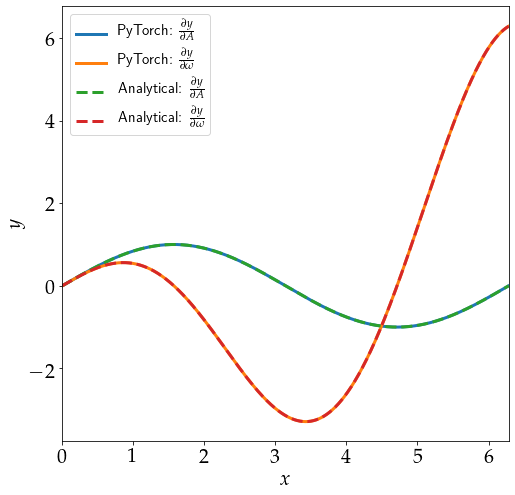

In [31]:
plt.figure(figsize = (8,8))
plt.plot(x, g[:,0], lw = 3, label = r'PyTorch: $\frac{\partial y}{\partial A}$')
plt.plot(x, g[:,1], lw = 3, label = r'PyTorch: $\frac{\partial y}{\partial \omega}$')
plt.plot(x, torch.sin(p[1].item()*x), lw = 3, label = r'Analytical: $\frac{\partial y}{\partial A}$', linestyle = '--')
plt.plot(x, p[0].item()*x*torch.cos(p[1].item()*x), lw = 3, label = r'Analytical: $\frac{\partial y}{\partial \omega}$', linestyle = '--')
plt.xlim(x.min(), x.max())
plt.ylabel(r'$y$', fontsize = fontSize)
plt.xlabel(r'$x$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
plt.show()

$y=ax^{2}+bx$

$\frac{\partial y}{\partial a} = x^{2}$

$\frac{\partial y}{\partial b} = x$

In [32]:
gquad = derivatives(x, p, sin = False)

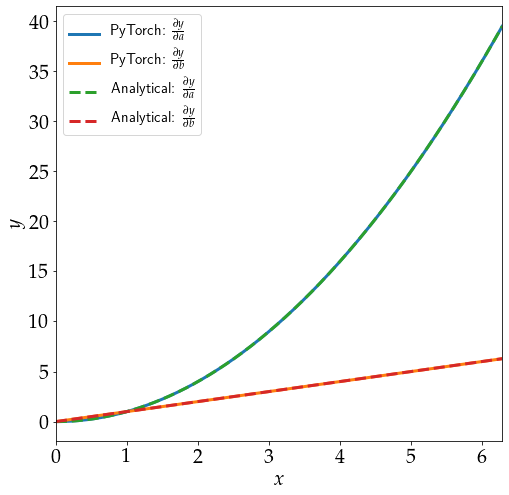

In [33]:
plt.figure(figsize = (8,8))
plt.plot(x, gquad[:,0], lw = 3, label = r'PyTorch: $\frac{\partial y}{\partial a}$')
plt.plot(x, gquad[:,1], lw = 3, label = r'PyTorch: $\frac{\partial y}{\partial b}$')
plt.plot(x, x**2, lw = 3, label = r'Analytical: $\frac{\partial y}{\partial a}$', linestyle = '--')
plt.plot(x, x, lw = 3, label = r'Analytical: $\frac{\partial y}{\partial b}$', linestyle = '--')
plt.xlim(x.min(), x.max())
plt.ylabel(r'$y$', fontsize = fontSize)
plt.xlabel(r'$x$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
plt.show()

# Evidence with MOPED

<img src="figures/moped-evidence.png" align="center" width="480"/>


Equation 24 corresponds to Equation 16 in Justin's paper (good), that is, we are using the unorthogonalised version of MOPED. 

**Equation 16 in Alan's Draft** 

$$\mathbf{b}_{\alpha}^{\textrm{T}}\equiv \mathbf{\mu}_{,\alpha}^{\textrm{T}}\mathbf{C}^{-1}$$

**Gradient Calculation**

In [34]:
grad_sin = derivatives(xinputs, torch.tensor(sin_mle), sin = True)
grad_quad = derivatives(xinputs, torch.tensor(quad_mle), sin = False)

**Covariance Calculation**

In [35]:
covariance = torch.from_numpy(np.diag([sigma**2]*ndata)).float()
covariance_inv = torch.from_numpy(np.diag([1.0/sigma**2]*ndata)).float()

**The MOPED vectors**

In [36]:
B_sin = torch.matmul(grad_sin.t(), covariance_inv)
B_quad = torch.matmul(grad_quad.t(), covariance_inv)

**The covariance of the compressed data**

In [37]:
Lambda_sin = torch.matmul(B_sin, torch.matmul(covariance, B_sin.t()))
Lambda_quad = torch.matmul(B_quad, torch.matmul(covariance, B_quad.t()))

Lambda_sin_inv = torch.linalg.inv(Lambda_sin)
Lambda_quad_inv = torch.linalg.inv(Lambda_quad)

**The theory calculated at the MLE**

In [38]:
theory_fid_sin = sinusoidal(xinputs, torch.tensor(sin_mle))
theory_fid_quad = quadratic(xinputs, torch.tensor(quad_mle))

**The compressed data**

In [39]:
sin_data_comp = torch.matmul(B_sin, data - theory_fid_sin)
quad_data_comp = torch.matmul(B_quad, data - theory_fid_quad)

# The Likelihood for MOPED

In [40]:
def loglike_moped(data: torch.tensor, xvalues: torch.tensor, parameters: torch.tensor, sin: bool = True):
    
    # need a better way to do this (from programming perspective)
    # we are also using: b_sin, b_quad, Lambda_sin_inv, Lambda_quad_inv
    if sin:
        model = sinusoidal(xvalues, parameters) 
        model = torch.matmul(B_sin, model - theory_fid_sin)
        
        epsilon = data - model 
        
        chi2 = torch.matmul(epsilon, torch.matmul(Lambda_sin_inv, epsilon))
        
        constant = torch.log(torch.linalg.det(2.0 * torch.pi * Lambda_sin))
        
    else:
        model = quadratic(xvalues, parameters) 
        model = torch.matmul(B_quad, model - theory_fid_quad)
        
        epsilon = data - model 
        
        chi2 = torch.matmul(epsilon, torch.matmul(Lambda_quad_inv, epsilon))
        
        constant = torch.log(torch.linalg.det(2.0 * torch.pi * Lambda_quad))
        
    return -0.5*(chi2 + constant)

## Likelihood Evaluations (with MOPED)

In [41]:
logL_sin_moped = list()
for a in amp:
    for g in ang:
        param = torch.tensor([a, g])
        logL_sin_moped.append(loglike_moped(sin_data_comp, xinputs, param, True))

In [42]:
logL_sin_moped = torch.FloatTensor(logL_sin_moped).view(npoints, npoints)

In [43]:
logL_quad_moped = list()
for a in a_quad:
    for b in b_quad:
        param = torch.tensor([a, b])
        logL_quad_moped.append(loglike_moped(quad_data_comp, xinputs, param, False))

In [44]:
logL_quad_moped = torch.FloatTensor(logL_quad_moped).view(npoints, npoints)

### Visualise the contours

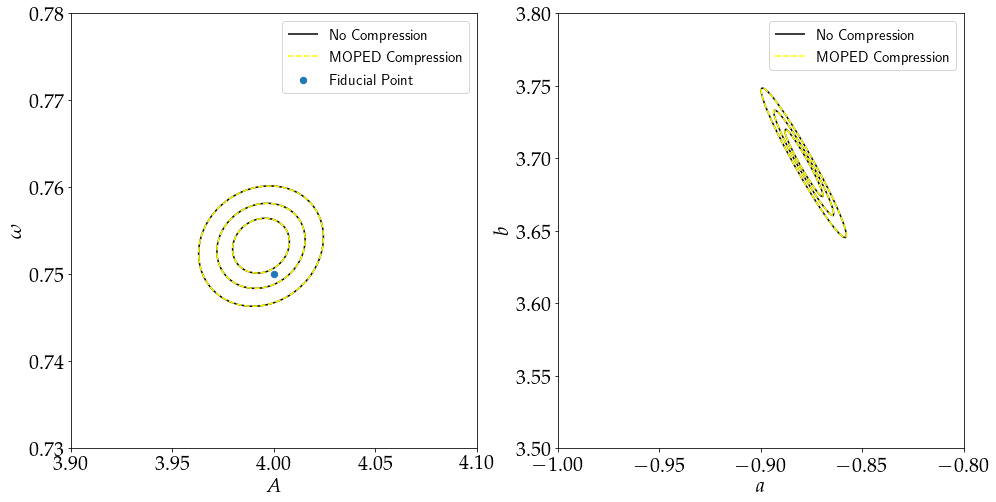

In [45]:
plt.figure(figsize = (16,8))

plt.subplot(121)
contours = plt.contour(amp_grid, ang_grid, torch.exp(logL_sin - torch.amax(logL_sin)), 3, colors='black')
contours_moped = plt.contour(amp_grid, ang_grid, torch.exp(logL_sin_moped - torch.amax(logL_sin_moped)), 3, colors='yellow',linestyles = 'dashed')
contours.collections[0].remove()
contours_moped.collections[0].remove()
scatter = plt.scatter([amplitude], [angFreq], s = 40)
plt.xlim(amp_min, amp_max)
plt.ylim(ang_min, ang_max)
plt.ylabel(r'$\omega$', fontsize = fontSize)
plt.xlabel(r'$A$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
h1,_ = contours.legend_elements()
h2,_ = contours_moped.legend_elements()
h3,_ = scatter.legend_elements()
plt.legend([h1[0], h2[0], scatter], ['No Compression', 'MOPED Compression', 'Fiducial Point'], loc = 'best',prop={'family':'sans-serif', 'size':15})

plt.subplot(122)
contours = plt.contour(a_grid, b_grid, torch.exp(logL_quad - torch.amax(logL_quad)), 3, colors='black')
contours_moped = plt.contour(a_grid, b_grid, torch.exp(logL_quad_moped - torch.amax(logL_quad_moped)), 3, colors='yellow',linestyles = 'dashed')
contours.collections[0].remove()
contours_moped.collections[0].remove()
plt.ylim(b_min, b_max)
plt.xlim(a_min, a_max)
plt.ylabel(r'$b$', fontsize = fontSize)
plt.xlabel(r'$a$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
h1,_ = contours.legend_elements()
h2,_ = contours_moped.legend_elements()
plt.legend([h1[0], h2[0]], ['No Compression', 'MOPED Compression'], loc = 'best',prop={'family':'sans-serif', 'size':15})

plt.show()

In [46]:
logL_sin_moped_max = torch.amax(logL_sin_moped).item()
logL_quad_moped_max = torch.amax(logL_quad_moped).item()

In [47]:
def logpost_sin_moped(amp, ang):
    
    # the parameters in a tensor 
    param = torch.tensor([amp, ang])
    
    # the log-likelihood value 
    logL = loglike_moped(sin_data_comp, xinputs, param, True) - logL_sin_moped_max
    
    # the log-prior 
    logp = prior_amp.log_prob(param[0]) + prior_ang.log_prob(param[1])
    
    return np.exp(logL + logp)

In [48]:
def logpost_quad_moped(a_val, b_val):
    
    # the parameters in a tensor 
    param = torch.tensor([a_val, b_val])
    
    # the log-likelihood value 
    logL = loglike_moped(quad_data_comp, xinputs, param, False) - logL_quad_moped_max
    
    # the log-prior 
    logp = prior_a.log_prob(param[0]) + prior_b.log_prob(param[1])
    
    return np.exp(logL + logp)

In [49]:
# to check the limit of the integration (make sure all posterior mass is concentrated)
int_sin_moped = dblquad(logpost_sin_moped, ang_min, ang_max, lambda amp:amp_min, lambda amp: amp_max)
int_quad_moped = dblquad(logpost_quad_moped, b_min, b_max, lambda a_val:a_min, lambda a_val:a_max)

In [50]:
evidence_sin_moped = np.exp(logL_sin_moped_max) * int_sin_moped[0]
evidence_quad_moped = np.exp(logL_quad_moped_max) * int_quad_moped[0]

In [51]:
logBayes_moped = np.log(evidence_sin_moped) - np.log(evidence_quad_moped)

In [52]:
print(f'The evidence (in log) for the sinusoidal model is {np.log(evidence_sin_moped):.2f}')
print(f'The evidence (in log) for the quadratic model is {np.log(evidence_quad_moped):.2f}')
print(f'The Bayes Factor (in log) between the sinusoidal and quadradic models is {logBayes_moped:.2f}')

The evidence (in log) for the sinusoidal model is -20.81
The evidence (in log) for the quadratic model is -20.35
The Bayes Factor (in log) between the sinusoidal and quadradic models is -0.46


In [53]:
# The evidence (in log) for the sinusoidal model is 80.78
# The evidence (in log) for the quadratic model is 42.71
# The Bayes Factor (in log) between the sinusoidal and quadradic models is 38.07

# The evidence (in log) for the sinusoidal model is -22.16
# The evidence (in log) for the quadratic model is -21.73
# The Bayes Factor (in log) between the sinusoidal and quadradic models is -0.42

# ----------------------------------------------------------------------
# The evidence (in log) for the sinusoidal model is 86.05
# The evidence (in log) for the quadratic model is 24.59
# The Bayes Factor (in log) between the sinusoidal and quadradic models is 61.47

# The evidence (in log) for the sinusoidal model is -22.15
# The evidence (in log) for the quadratic model is -21.73
# The Bayes Factor (in log) between the sinusoidal and quadradic models is -0.42

# ----------------------------------------------------------------------
# The evidence (in log) for the sinusoidal model is 75.45
# The evidence (in log) for the quadratic model is 36.41
# The Bayes Factor (in log) between the sinusoidal and quadradic models is 39.04

# The evidence (in log) for the sinusoidal model is -22.16
# The evidence (in log) for the quadratic model is -21.73
# The Bayes Factor (in log) between the sinusoidal and quadradic models is -0.43

# ----------------------------------------------------------------------
# The evidence (in log) for the sinusoidal model is 74.75
# The evidence (in log) for the quadratic model is 23.31
# The Bayes Factor (in log) between the sinusoidal and quadradic models is 51.45

# The evidence (in log) for the sinusoidal model is -22.14
# The evidence (in log) for the quadratic model is -21.74
# The Bayes Factor (in log) between the sinusoidal and quadradic models is -0.40